In [0]:
# import packages
import torch
import torch.nn as nn
import torch.optim as optim

import torchtext
from torchtext.datasets import TranslationDataset, Multi30k
from torchtext.data import Field, Iterator
from torchtext.data import batch as ttbatch

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import spacy
import numpy as np

import os
import random
import math
import time
from tqdm import tqdm

In [0]:
# !pip install sentencepiece

In [0]:
import sentencepiece as spm

In [4]:
# mount google drive
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# !python -m spacy download de_core_news_sm
# !python -m spacy download en_core_web_sm

In [0]:
# set random seed for reproducibility

SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
# torch.backends.cudnn.deterministic = True

In [0]:
# spacy_de = spacy.load("de_core_news_sm")
# spacy_en = spacy.load('en_core_web_sm')

In [0]:
# def tokenize_de(text):
#     """
#     Tokenizes German text from a string into a list of strings
#     """
#     return [tok.text for tok in spacy_de.tokenizer(text)]

# def tokenize_en(text):
#     """
#     Tokenizes English text from a string into a list of strings
#     """
#     return [tok.text for tok in spacy_en.tokenizer(text)]

In [0]:
import shutil
 
def copyDirectory(src, dest):
    try:
        shutil.copytree(src, dest)
    # Directories are the same
    except shutil.Error as e:
        print('Directory not copied. Error: %s' % e)
    # Any error saying that the directory doesn't exist
    except OSError as e:
        print('Directory not copied. Error: %s' % e)

In [74]:
data_dir_drive = os.path.join('gdrive', 'My Drive', 'EN-OD translation', 'data')
data_dir = 'data'
copyDirectory(data_dir_drive, data_dir)

Directory not copied. Error: [Errno 17] File exists: 'data'


In [75]:
print(os.listdir(data_dir))

['corpus.en', 'corpus.od', 'test.od', 'dev.od', 'test.en', 'bpe_en_od_vsize16k.vocab', 'dev.en', 'bpe_en_od_vsize16k.model']


In [76]:
!head data/corpus.od

ଭିଡିଓ ବିଜ୍ଞାପନ
ଭିଡିଓ ବିଜ୍ଞାପନ
ଗୋପନୀୟତା
ଅପଠିତ
ରିଚାର୍ଜ୍ ଦୋକାନ
ପ୍ରିସେଟ୍‌ ଅଧ୍ୟୟନ
ଡିଫଲ୍ଟ ବିଜ୍ଞାପନ
ଗୁରୁତ୍ୱପୂର୍ଣ୍ଣ ବିଭାଜନ
ବିଜ୍ଞାପନ ପରିଚାଳକ
ଅନୁକୂଳ କରାଇବା


In [78]:
for filename in sorted(os.listdir(data_dir)):
  print(f"{filename:10}: {sum(1 for line in open(os.path.join(data_dir, filename), 'r', encoding='utf-8'))}")

UnicodeDecodeError: ignored

In [18]:
spm.SentencePieceTrainer.train(f'--input={data_dir}/corpus.en,{data_dir}/corpus.od --model_prefix={data_dir}/bpe_en_od_vsize16k --vocab_size=16000 --model_type=bpe')
sp_bpe = spm.SentencePieceProcessor()
sp_bpe.load(f'{data_dir}/bpe_en_od_vsize16k.model')

True

In [19]:
!wc -l data/bpe_en_od_vsize16k.vocab

16000 data/bpe_en_od_vsize16k.vocab


In [0]:
SRC = Field(tokenize = sp_bpe.encode_as_pieces, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = False,
            batch_first = True)

TRG = Field(tokenize = sp_bpe.encode_as_pieces,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = False,
            batch_first = True)

In [0]:
train_data, valid_data, test_data = TranslationDataset.splits(
    path=data_dir,
    exts=('.en', '.od'),
    train='corpus',
    validation='dev',
    test='test',
    fields=(SRC, TRG)
  )

In [0]:
SRC.build_vocab(train_data, min_freq=1, max_size=8000)
TRG.build_vocab(train_data, min_freq=1, max_size=8000)

In [80]:
print(f'sizes of vocab:\nen={len(SRC.vocab)}\nod={len(TRG.vocab)}')

sizes of vocab:
en=8004
od=8004


In [0]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [0]:
# global variables
global MAX_SRC_IN_BATCH, MAX_TRG_IN_BATCH


# batch size function for MinPadIterator
def batch_size_fn(new, count, sofar):
    """Keep augmenting batch and calculate total number of tokens + padding."""
    global MAX_SRC_IN_BATCH, MAX_TRG_IN_BATCH
    if count == 1:
        MAX_SRC_IN_BATCH = 0
        MAX_TRG_IN_BATCH = 0
    MAX_SRC_IN_BATCH = max(MAX_SRC_IN_BATCH, len(new.src))
    MAX_TRG_IN_BATCH = max(MAX_TRG_IN_BATCH, len(new.trg) + 2)
    src_elements = count * MAX_SRC_IN_BATCH
    trg_elements = count * MAX_TRG_IN_BATCH
    return max(src_elements, trg_elements)


# iterator to minimize padding
class MinPadIterator(Iterator):
    def create_batches(self):

        def pool(d, random_shuffler):
            for p in ttbatch(d, self.batch_size * 100):
                p_batch = ttbatch(
                    sorted(p, key=self.sort_key),
                    self.batch_size, self.batch_size_fn)
                for b in random_shuffler(list(p_batch)):
                    yield b

        self.batches = pool(self.data(), self.random_shuffler)

In [0]:
BATCH_SIZE = 4096

# train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
#     (train_data, valid_data, test_data), 
#      batch_size = BATCH_SIZE,
#      device = device)

train_iterator = MinPadIterator(
      train_data,
      batch_size=BATCH_SIZE,
      shuffle=True,
      sort_key=lambda x: (len(x.src), len(x.trg)),
      batch_size_fn=batch_size_fn,
      device=device
  )
valid_iterator = MinPadIterator(
      valid_data,
      batch_size=BATCH_SIZE,
      shuffle=False,
      sort_key=lambda x: (len(x.src), len(x.trg)),
      batch_size_fn=batch_size_fn,
      device=device
  )
test_iterator = MinPadIterator(
      test_data,
      batch_size=BATCH_SIZE,
      shuffle=False,
      sort_key=lambda x: (len(x.src), len(x.trg)),
      batch_size_fn=batch_size_fn,
      device=device
  )

In [0]:
class Encoder(nn.Module):
    def __init__(self, 
                 input_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim, 
                 encoder_layer, 
                 self_attention_layer, 
                 positionwise_feedforward_layer, 
                 dropout, 
                 device):
        super().__init__()

        self.device = device
        
        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        self.pos_embedding = nn.Embedding(1000, hid_dim)
        
        self.layers = nn.ModuleList([encoder_layer(hid_dim, 
                                                   n_heads, 
                                                   pf_dim, 
                                                   self_attention_layer, 
                                                   positionwise_feedforward_layer, 
                                                   dropout, 
                                                   device) 
                                     for _ in range(n_layers)])
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len]
        #src_mask = [batch size, src len]
        
        batch_size = src.shape[0]
        src_len = src.shape[1]
        
        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        
        #pos = [batch size, src len]
        
        src = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))
        
        #src = [batch size, src len, hid dim]
        
        for layer in self.layers:
            src = layer(src, src_mask)
            
        #src = [batch size, src len, hid dim]
            
        return src

In [0]:
class EncoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim, 
                 self_attention_layer, 
                 positionwise_feedforward_layer, 
                 dropout, 
                 device):
        super().__init__()
        
        self.layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = self_attention_layer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = positionwise_feedforward_layer(hid_dim, 
                                                                       pf_dim, 
                                                                       dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len, hid dim]
        #src_mask = [batch size, src len]
                
        #self attention
        _src, _ = self.self_attention(src, src, src, src_mask)
        
        #dropout, residual connection and layer norm
        src = self.layer_norm(src + self.dropout(_src))
        
        #src = [batch size, src len, hid dim]
        
        #positionwise feedforward, dropout, residual and layer norm
        src = self.layer_norm(src + self.dropout(self.positionwise_feedforward(src)))
        
        #src = [batch size, src len, hid dim]
        
        return src

In [0]:
class SelfAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device):
        super().__init__()
        
        assert hid_dim % n_heads == 0
        
        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.head_dim = hid_dim // n_heads
        
        self.fc_q = nn.Linear(hid_dim, hid_dim)
        self.fc_k = nn.Linear(hid_dim, hid_dim)
        self.fc_v = nn.Linear(hid_dim, hid_dim)
        
        self.fc = nn.Linear(hid_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
        
    def forward(self, query, key, value, mask = None):
        
        batch_size = query.shape[0]
        
        #query = [batch size, query len, hid dim]
        #key = [batch size, key len, hid dim]
        #value = [batch size, value len, hid dim]
                
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)
        
        #Q = [batch size, query len, hid dim]
        #K = [batch size, key len, hid dim]
        #V = [batch size, value len, hid dim]
                
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        
        #Q = [batch size, n heads, query len, head dim]
        #K = [batch size, n heads, key len, head dim]
        #V = [batch size, n heads, value len, head dim]
                
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale
        
        #energy = [batch size, n heads, seq len, seq len]
        
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)
        
        attention = torch.softmax(energy, dim = -1)
                
        #attention = [batch size, n heads, query len, key len]
        
        x = torch.matmul(self.dropout(attention), V)
        
        #x = [batch size, n heads, seq len, head dim]
        
        x = x.permute(0, 2, 1, 3).contiguous()
        
        #x = [batch size, seq len, n heads, head dim]
        
        x = x.view(batch_size, -1, self.hid_dim)
        
        #x = [batch size, seq len, hid dim]
        
        x = self.fc(x)
        
        #x = [batch size, seq len, hid dim]
        
        return x, attention

In [0]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        
        self.fc_1 = nn.Linear(hid_dim, pf_dim)
        self.fc_2 = nn.Linear(pf_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        
        #x = [batch size, seq len, hid dim]
        
        x = self.dropout(torch.relu(self.fc_1(x)))
        
        #x = [batch size, seq len, pf dim]
        
        x = self.fc_2(x)
        
        #x = [batch size, seq len, hid dim]
        
        return x

In [0]:
class Decoder(nn.Module):
    def __init__(self, 
                 output_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim, 
                 decoder_layer, 
                 self_attention_layer, 
                 positionwise_feedforward_layer, 
                 dropout, 
                 device):
        super().__init__()
        
        self.device = device
        
        self.tok_embedding = nn.Embedding(output_dim, hid_dim)
        self.pos_embedding = nn.Embedding(1000, hid_dim)
        
        self.layers = nn.ModuleList([decoder_layer(hid_dim, 
                                                   n_heads, 
                                                   pf_dim, 
                                                   self_attention_layer, 
                                                   positionwise_feedforward_layer, 
                                                   dropout, 
                                                   device)
                                     for _ in range(n_layers)])
        
        self.fc_out = nn.Linear(hid_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, trg len]
        #src_mask = [batch size, src len]
                
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
        
        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
                            
        #pos = [batch size, trg len]
            
        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))
                
        #trg = [batch size, trg len, hid dim]
        
        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        output = self.fc_out(trg)
        
        #output = [batch size, trg len, output dim]
            
        return output, attention

In [0]:
class DecoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim, 
                 self_attention_layer, 
                 positionwise_feedforward_layer, 
                 dropout, 
                 device):
        super().__init__()
        
        self.layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = self_attention_layer(hid_dim, n_heads, dropout, device)
        self.encoder_attention = self_attention_layer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = positionwise_feedforward_layer(hid_dim, 
                                                                       pf_dim, 
                                                                       dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len, hid dim]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, trg len]
        #src_mask = [batch size, src len]
        
        #self attention
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
        
        #dropout, residual connection and layer norm
        trg = self.layer_norm(trg + self.dropout(_trg))
            
        #trg = [batch size, trg len, hid dim]
            
        #encoder attention
        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)
        
        #dropout, residual connection and layer norm
        trg = self.layer_norm(trg + self.dropout(_trg))
                    
        #trg = [batch size, trg len, hid dim]
        
        #positionwise feedforward, dropout, residual and layer norm
        trg = self.layer_norm(trg + self.dropout(self.positionwise_feedforward(trg)))
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return trg, attention

In [0]:
class Seq2Seq(nn.Module):
    def __init__(self, 
                 encoder, 
                 decoder, 
                 src_pad_idx, 
                 trg_pad_idx, 
                 trg_sos_idx, 
                 device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.trg_sos_idx = trg_sos_idx
        self.device = device
        
    def make_src_mask(self, src):
        
        #src = [batch size, src len]
        
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)

        #src_mask = [batch size, 1, 1, src len]

        return src_mask
    
    def make_trg_mask(self, trg):
        
        #trg = [batch size, trg len]
        
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(3)
        
        #trg_pad_mask = [batch size, 1, trg len, 1]
        
        trg_len = trg.shape[1]
        
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()
        
        #trg_sub_mask = [trg len, trg len]
            
        trg_mask = trg_pad_mask & trg_sub_mask
        
        #trg_mask = [batch size, 1, trg len, trg len]
        
        return trg_mask

    def forward(self, src, trg):
        
        #src = [batch size, src len]
        #trg = [batch size, trg len]
                
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)
        
        #src_mask = [batch size, 1, 1, src len]
        #trg_mask = [batch size, 1, trg len, trg len]
        
        enc_src = self.encoder(src, src_mask)
        
        #enc_src = [batch size, src len, hid dim]
                
        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)
        
        #output = [batch size, trg len, output dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return output, attention


In [0]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
HID_DIM = 256
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

enc = Encoder(INPUT_DIM, 
              HID_DIM, 
              ENC_LAYERS, 
              ENC_HEADS, 
              ENC_PF_DIM, 
              EncoderLayer, 
              SelfAttentionLayer, 
              PositionwiseFeedforwardLayer, 
              ENC_DROPOUT, 
              device)

dec = Decoder(OUTPUT_DIM, 
              HID_DIM, 
              DEC_LAYERS, 
              DEC_HEADS, 
              DEC_PF_DIM, 
              DecoderLayer, 
              SelfAttentionLayer, 
              PositionwiseFeedforwardLayer, 
              DEC_DROPOUT, 
              device)

In [0]:
SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]
TRG_SOS_IDX = TRG.vocab.stoi[TRG.init_token]

model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, TRG_SOS_IDX, device).to(device)

In [94]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 10,616,132 trainable parameters


In [0]:
# xavier initialization

def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

In [0]:
model.apply(initialize_weights);

In [0]:
LEARNING_RATE = 0.0005

optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

In [0]:
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

In [0]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0

    tqdm_meter = tqdm(iterator, unit=' batches', desc=f'[EPOCH {epoch}/{N_EPOCHS}]', leave=False, total=0)
    
    for i, batch in enumerate(tqdm_meter):
        
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output, _ = model(src, trg[:,:-1])
                
        #output = [batch size, trg len - 1, output dim]
        #trg = [batch size, trg len]
            
        output_dim = output.shape[-1]
            
        output = output.contiguous().view(-1, output_dim)
        trg = trg[:,1:].contiguous().view(-1)
                
        #output = [batch size * trg len - 1, output dim]
        #trg = [batch size * trg len - 1]
            
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()

        # update tqdm meter
        tqdm_meter.set_postfix(loss=f'{loss.item():0.4f}', ppl=f'{math.exp(loss.item()):0.2f}')
        tqdm_meter.update()

    return epoch_loss / (i + 1)

In [0]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(tqdm(iterator, unit=' batches', leave=False, total=0)):

            src = batch.src
            trg = batch.trg

            output, _ = model(src, trg[:,:-1])
            
            #output = [batch size, trg len - 1, output dim]
            #trg = [batch size, trg len]
            
            output_dim = output.shape[-1]
            
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)
            
            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]
            
            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / (i + 1)

In [0]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [102]:
N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(1, N_EPOCHS + 1):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'model.pt')
    
    print(f'Epoch: {epoch:02} (^_^) Time: {epoch_mins}m {epoch_secs}s', end='')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}', end='')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

[EPOCH 2/10]: 0 batches [00:00, ? batches/s]

Epoch: 01 (^_^) Time: 0m 54s	Train Loss: 7.203 | Train PPL: 1343.568	 Val. Loss: 6.709 |  Val. PPL: 820.119


[EPOCH 3/10]: 0 batches [00:00, ? batches/s]

Epoch: 02 (^_^) Time: 0m 55s	Train Loss: 5.996 | Train PPL: 402.012	 Val. Loss: 6.083 |  Val. PPL: 438.261


[EPOCH 4/10]: 1 batches [00:00,  5.37 batches/s, loss=4.4719, ppl=87.52]

Epoch: 03 (^_^) Time: 0m 54s	Train Loss: 5.279 | Train PPL: 196.117	 Val. Loss: 5.261 |  Val. PPL: 192.643


[EPOCH 5/10]: 0 batches [00:00, ? batches/s]

Epoch: 04 (^_^) Time: 0m 54s	Train Loss: 4.785 | Train PPL: 119.664	 Val. Loss: 4.738 |  Val. PPL: 114.192


[EPOCH 6/10]: 0 batches [00:00, ? batches/s]

Epoch: 05 (^_^) Time: 0m 54s	Train Loss: 4.422 | Train PPL:  83.237	 Val. Loss: 4.339 |  Val. PPL:  76.594


[EPOCH 7/10]: 0 batches [00:00, ? batches/s]

Epoch: 06 (^_^) Time: 0m 54s	Train Loss: 4.132 | Train PPL:  62.307	 Val. Loss: 4.016 |  Val. PPL:  55.503


[EPOCH 8/10]: 0 batches [00:00, ? batches/s]

Epoch: 07 (^_^) Time: 0m 54s	Train Loss: 3.880 | Train PPL:  48.439	 Val. Loss: 3.782 |  Val. PPL:  43.916


[EPOCH 9/10]: 0 batches [00:00, ? batches/s]

Epoch: 08 (^_^) Time: 0m 54s	Train Loss: 3.655 | Train PPL:  38.671	 Val. Loss: 3.501 |  Val. PPL:  33.138


[EPOCH 10/10]: 0 batches [00:00, ? batches/s]

Epoch: 09 (^_^) Time: 0m 55s	Train Loss: 3.453 | Train PPL:  31.590	 Val. Loss: 3.355 |  Val. PPL:  28.657


Epoch: 10 (^_^) Time: 0m 54s	Train Loss: 3.267 | Train PPL:  26.220	 Val. Loss: 3.289 |  Val. PPL:  26.816


In [103]:
model.load_state_dict(torch.load('model.pt'))

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 3.289 | Test PPL:  26.816 |


In [0]:
def translate_sentence(sentence, src_field, trg_field, model, device, max_len = 50):
    
    model.eval()

    tokens = [src_field.init_token] + sentence + [src_field.eos_token]
        
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]

    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)
    
    src_mask = model.make_src_mask(src_tensor)
    
    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask)

    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    for i in range(max_len):

        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)

        trg_mask = model.make_trg_mask(trg_tensor)
        
        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)
        
        pred_token = output.argmax(2)[:,-1].item()
        
        trg_indexes.append(pred_token)

        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break
    
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]
    
    return trg_tokens[1:], attention

In [0]:
def display_attention(sentence, translation, attention, n_heads = 8, n_rows = 4, n_cols = 2):
    
    assert n_rows * n_cols == n_heads
    
    fig = plt.figure(figsize=(15,25))
    
    for i in range(1, n_heads+1):
        
        ax = fig.add_subplot(n_rows, n_cols,i)
        
        _attention = attention.squeeze(0)[i-1].cpu().detach().numpy()

        cax = ax.matshow(_attention, cmap='Oranges')

        ax.tick_params(labelsize=12)
        ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'], 
                           rotation=45)
        ax.set_yticklabels(['']+translation)

        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

In [106]:
example_idx = 100

src = vars(train_data.examples[example_idx])['src']
trg = vars(train_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['▁multi', '-', 't', 'ou', 'ch', '▁att', 'ribution']
trg = ['▁ବହୁ', '-', 'ସ୍ପ', 'ର୍ଶ', '▁ଆରୋ', 'ପଣ']


In [107]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

predicted trg = ['<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>']


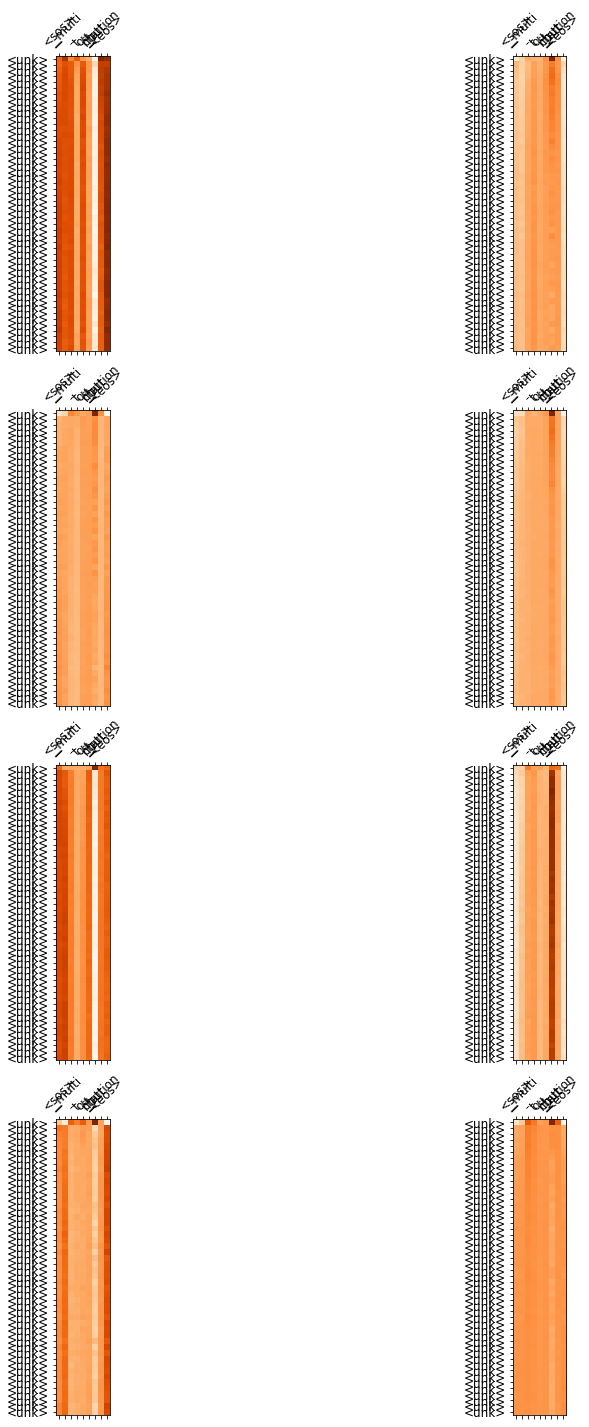

In [108]:
display_attention(src, translation, attention)

In [0]:
import collections

def ngrams_iterator(token_list, ngrams):
    """Return an iterator that yields the given tokens and their ngrams.
    Arguments:
        token_list: A list of tokens
        ngrams: the number of ngrams.
    Examples:
        >>> token_list = ['here', 'we', 'are']
        >>> list(ngrams_iterator(token_list, 2))
        >>> ['here', 'here we', 'we', 'we are', 'are']
    """

    def _get_ngrams(n):
        return zip(*[token_list[i:] for i in range(n)])

    for x in token_list:
        yield x
    for n in range(2, ngrams + 1):
        for x in _get_ngrams(n):
            yield ' '.join(x)


def _compute_ngram_counter(tokens, max_n):
    """ Create a Counter with a count of unique n-grams in the tokens list
    Arguments:
        tokens: a list of tokens (typically a string split on whitespaces)
        max_n: the maximum order of n-gram wanted
    Outputs:
        output: a collections.Counter object with the unique n-grams and their
            associated count
    Examples:
        >>> from torchtext.data.metrics import _compute_ngram_counter
        >>> tokens = ['me', 'me', 'you']
        >>> _compute_ngram_counter(tokens, 2)
            Counter({('me',): 2,
             ('you',): 1,
             ('me', 'me'): 1,
             ('me', 'you'): 1,
             ('me', 'me', 'you'): 1})
    """
    assert max_n > 0
    ngrams_counter = collections.Counter(tuple(x.split(' '))
                                         for x in ngrams_iterator(tokens, max_n))

    return ngrams_counter


def bleu_score(candidate_corpus, references_corpus, max_n=4, weights=[0.25] * 4):
    """Computes the BLEU score between a candidate translation corpus and a references
    translation corpus. Based on https://www.aclweb.org/anthology/P02-1040.pdf
    Arguments:
        candidate_corpus: an iterable of candidate translations. Each translation is an
            iterable of tokens
        references_corpus: an iterable of iterables of reference translations. Each
            translation is an iterable of tokens
        max_n: the maximum n-gram we want to use. E.g. if max_n=3, we will use unigrams,
            bigrams and trigrams
        weights: a list of weights used for each n-gram category (uniform by default)
    Examples:
        >>> from torchtext.data.metrics import bleu_score
        >>> candidate_corpus = [['I', 'ate', 'the', 'apple'], ['I', 'did']]
        >>> references_corpus = [[['I', 'ate', 'it'], ['I', 'ate', 'apples']],
                [['I', 'did']]]
        >>> bleu_score(candidate_corpus, references_corpus)
            0.7598356856515925
    """

    assert max_n == len(weights), 'Length of the "weights" list has be equal to max_n'
    assert len(candidate_corpus) == len(references_corpus),\
        'The length of candidate and reference corpus should be the same'

    clipped_counts = torch.zeros(max_n)
    total_counts = torch.zeros(max_n)
    weights = torch.tensor(weights)

    candidate_len = 0.0
    refs_len = 0.0

    for (candidate, refs) in zip(candidate_corpus, references_corpus):
        candidate_len += len(candidate)

        # Get the length of the reference that's closest in length to the candidate
        refs_len_list = [float(len(ref)) for ref in refs]
        refs_len += min(refs_len_list, key=lambda x: abs(len(candidate) - x))

        reference_counters = _compute_ngram_counter(refs[0], max_n)
        for ref in refs[1:]:
            reference_counters = reference_counters | _compute_ngram_counter(ref, max_n)

        candidate_counter = _compute_ngram_counter(candidate, max_n)

        clipped_counter = candidate_counter & reference_counters

        for ngram in clipped_counter:
            clipped_counts[len(ngram) - 1] += clipped_counter[ngram]

        for ngram in candidate_counter:  # TODO: no need to loop through the whole counter
            total_counts[len(ngram) - 1] += candidate_counter[ngram]

    if min(clipped_counts) == 0:
        return 0.0
    else:
        pn = clipped_counts / total_counts
        log_pn = weights * torch.log(pn)
        score = torch.exp(sum(log_pn))

        bp = math.exp(min(1 - refs_len / candidate_len, 0))

        return bp * score.item()

In [0]:
def translate_sentences(data, src_field, trg_field, model, device, max_len = 50):
    
    trgs = []
    pred_trgs = []
    
    for datum in tqdm(data, unit=' samples'):
        
        src = vars(datum)['src']
        trg = vars(datum)['trg']
        
        pred_trg, _ = translate_sentence(src, src_field, trg_field, model, device, max_len)
        
        #cut off <eos> token
        pred_trg = pred_trg[:-1]
        
        trgs.append([trg])
        pred_trgs.append(pred_trg)
        
    return trgs, pred_trgs

In [111]:
labels, preds = translate_sentences(test_data, SRC, TRG, model, device)

  6%|▌         | 223/3922 [00:33<09:59,  6.17 samples/s]

KeyboardInterrupt: ignored

In [0]:
# !pip install sacrebleu
import sacrebleu

In [0]:
outs = preds
refs = labels
outs_str = list(map(lambda l: sp_bpe.decode_pieces(l), outs))
refs_str = [list(map(lambda l: sp_bpe.decode_pieces(l[0]), refs))]

In [68]:
print(f'BLEU score = {bleu_score(outs, refs)*100:.2f}')
print(f'SACREBLEU score = {sacrebleu.corpus_bleu(outs_str, refs_str, force=False).score:.2f}')

BLEU score = 0.00
SACREBLEU score = 0.02
